In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.cuda.amp as amp

In [35]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = 512
LR = 0.001
NUM_CLASSES = 20

In [78]:
TRAIN_IMG_DIR = 'img_train'
TEST_IMG_DIR = 'img_test'
TRAIN_LABELS_PATH = 'train_answers.csv'

In [79]:
train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=20,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
    ),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [80]:
class ActivityDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels = labels_df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path} | {e}")
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
            
        if self.transform:
            image = self.transform(image)
            
        return image, label

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = sorted(
            [f for f in os.listdir(img_dir) if f.endswith('.jpg')],
            key=lambda x: int(x.split('.')[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        img_id = int(self.image_files[idx].split('.')[0])
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


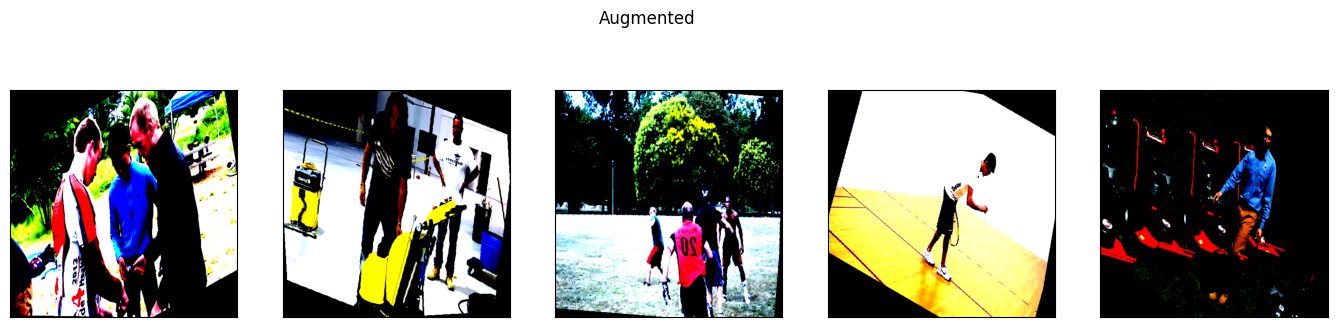

In [81]:
labels_df = pd.read_csv(TRAIN_LABELS_PATH)

train_data_augm = ActivityDataset(img_dir=TRAIN_IMG_DIR, labels_df=labels_df, transform=train_transform)

plt.figure(figsize=(17, 4))
plt.suptitle("Augmented")
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image_aug, label_aug = train_data_augm[i]
    plt.imshow(image_aug.squeeze().permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [82]:
# ShuffleNetV2
def channel_shuffle(x, groups):
    batchsize, num_channels, height, width = x.data.size()
    channels_per_group = num_channels // groups
    x = x.view(batchsize, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batchsize, -1, height, width)
    return x

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        branch_features = oup // 2
        
        assert self.stride in [1, 2]
        
        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True)
            )
        else:
            self.branch1 = nn.Sequential()
            
        self.branch2 = nn.Sequential(
            nn.Conv2d(inp if (self.stride > 1) else branch_features, 
                      branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True)
        )
        
    @staticmethod
    def depthwise_conv(i, o, kernel_size, stride):
        return nn.Conv2d(i, o, kernel_size, stride, (kernel_size-1)//2, groups=i, bias=False)
    
    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)
            
        out = channel_shuffle(out, 2)
        return out

class ShuffleNetV2(nn.Module):
    def __init__(self, stages_repeats=[4, 8, 4], stages_out_channels=[24, 176, 352, 704, 1024], num_classes=20):
        super(ShuffleNetV2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, stages_out_channels[0], 3, 2, 1, bias=False),
            nn.BatchNorm2d(stages_out_channels[0]),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.stages = []
        for idxstage in range(len(stages_repeats)):
            stage = self._make_stage(stages_out_channels[idxstage], 
                                     stages_out_channels[idxstage+1], 
                                     stages_repeats[idxstage])
            self.stages.append(stage)
            self.add_module(f'stage{idxstage+2}', stage)
            
        self.conv5 = nn.Sequential(
            nn.Conv2d(stages_out_channels[-2], stages_out_channels[-1], 1, 1, 0, bias=False),
            nn.BatchNorm2d(stages_out_channels[-1]),
            nn.ReLU(inplace=True)
        )
        
        self.globalpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(stages_out_channels[-1], num_classes)
        
    def _make_stage(self, inp, oup, repeat):
        layers = []
        layers.append(InvertedResidual(inp, oup, stride=2))
        for _ in range(repeat-1):
            layers.append(InvertedResidual(oup, oup, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        for stage in self.stages:
            x = stage(x)
        x = self.conv5(x)
        x = self.globalpool(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [83]:
full_labels = pd.read_csv(TRAIN_LABELS_PATH)

train_labels, val_labels = train_test_split(
    full_labels, test_size=0.1, stratify=full_labels['target_feature'], random_state=42
)

train_dataset = ActivityDataset(TRAIN_IMG_DIR, train_labels, train_transform)
val_dataset = ActivityDataset(TRAIN_IMG_DIR, val_labels, test_transform)

# Весовое семплирование
all_class_counts = full_labels['target_feature'].value_counts().sort_index()
class_weights_full = 1.0 / all_class_counts

# Обеспечим, что для всех классов (0 до NUM_CLASSES-1) заданы веса
class_weights_full = class_weights_full.reindex(range(NUM_CLASSES), fill_value=0.0)

weights = torch.DoubleTensor([class_weights_full[label] for label in train_labels['target_feature']])
sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [84]:
model = ShuffleNetV2(num_classes=NUM_CLASSES).to(DEVICE)
print("Model summary:")
summary(model, (3, IMG_SIZE, IMG_SIZE))

Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 256, 256]             648
       BatchNorm2d-2         [-1, 24, 256, 256]              48
              ReLU-3         [-1, 24, 256, 256]               0
         MaxPool2d-4         [-1, 24, 128, 128]               0
            Conv2d-5           [-1, 24, 64, 64]             216
       BatchNorm2d-6           [-1, 24, 64, 64]              48
            Conv2d-7           [-1, 88, 64, 64]           2,112
       BatchNorm2d-8           [-1, 88, 64, 64]             176
              ReLU-9           [-1, 88, 64, 64]               0
           Conv2d-10         [-1, 88, 128, 128]           2,112
      BatchNorm2d-11         [-1, 88, 128, 128]             176
             ReLU-12         [-1, 88, 128, 128]               0
           Conv2d-13           [-1, 88, 64, 64]             792
      BatchNorm2d-14    

In [85]:
class_weights_tensor = torch.FloatTensor(class_weights_full.values).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
scaler = amp.GradScaler()

In [86]:
def train_model():
    best_f1 = 0.0
    history = {'train_loss': [], 'val_f1': [], 'val_acc': [], 'val_precision': [], 'val_recall': []}
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
        
        for images, labels in progress:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            progress.set_postfix({'loss': f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(train_dataset)
        
        # Валидация
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True)
                
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Расчет метрик
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, average='weighted')
        epoch_recall = recall_score(all_labels, all_preds, average='weighted')
        
        history['train_loss'].append(epoch_loss)
        history['val_f1'].append(epoch_f1)
        history['val_acc'].append(epoch_acc)
        history['val_precision'].append(epoch_precision)
        history['val_recall'].append(epoch_recall)
        
        # Сохранение лучшей модели
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), 'best_shufflenet.pth')
            print(f"Epoch {epoch+1}: Новая лучшая модель сохранена с F1: {epoch_f1:.4f}")
        
        scheduler.step(epoch_loss)
        
        print(f"\nEpoch {epoch+1}/{EPOCHS} завершена:")
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Val Accuracy: {epoch_acc:.4f}")
        print(f"Val F1: {epoch_f1:.4f}")
        print(f"Val Precision: {epoch_precision:.4f}")
        print(f"Val Recall: {epoch_recall:.4f}\n")
        
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history['val_f1'], label='F1-score', marker='o')
    plt.plot(history['val_acc'], label='Accuracy', marker='o')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history['val_precision'], label='Precision', marker='o')
    plt.plot(history['val_recall'], label='Recall', marker='o')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    return history

In [87]:
def predict_test():
    model.load_state_dict(torch.load('best_shufflenet.pth', map_location=DEVICE))
    model.eval()
    
    test_dataset = TestDataset(TEST_IMG_DIR, test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    preds = []
    ids = []
    
    with torch.no_grad():
        for images, batch_ids in tqdm(test_loader, desc="Predicting"):
            images = images.to(DEVICE)
            outputs = model(images)
            batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(batch_preds)
            ids.extend(batch_ids.numpy())
    
    pd.DataFrame({'Id': ids, 'target_feature': preds}).to_csv('shufflenet_submission.csv', index=False)
    print("Predictions saved to shufflenet_submission.csv")

c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Новая лучшая модель сохранена с F1: 0.0643

Epoch 1/100 завершена:
Train Loss: 2.3305
Val Accuracy: 0.0792
Val F1: 0.0643
Val Precision: 0.0713
Val Recall: 0.0792



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: Новая лучшая модель сохранена с F1: 0.0851

Epoch 2/100 завершена:
Train Loss: 2.1171
Val Accuracy: 0.1302
Val F1: 0.0851
Val Precision: 0.1724
Val Recall: 0.1302



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3: Новая лучшая модель сохранена с F1: 0.1302

Epoch 3/100 завершена:
Train Loss: 1.9380
Val Accuracy: 0.1762
Val F1: 0.1302
Val Precision: 0.1715
Val Recall: 0.1762



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 4/100 завершена:
Train Loss: 1.8352
Val Accuracy: 0.1560
Val F1: 0.1121
Val Precision: 0.1332
Val Recall: 0.1560



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5: Новая лучшая модель сохранена с F1: 0.1493

Epoch 5/100 завершена:
Train Loss: 1.6729
Val Accuracy: 0.2094
Val F1: 0.1493
Val Precision: 0.3552
Val Recall: 0.2094



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6: Новая лучшая модель сохранена с F1: 0.1712

Epoch 6/100 завершена:
Train Loss: 1.5710
Val Accuracy: 0.2312
Val F1: 0.1712
Val Precision: 0.3939
Val Recall: 0.2312



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7: Новая лучшая модель сохранена с F1: 0.2001

Epoch 7/100 завершена:
Train Loss: 1.4388
Val Accuracy: 0.2595
Val F1: 0.2001
Val Precision: 0.3306
Val Recall: 0.2595



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 8/100 завершена:
Train Loss: 1.3990
Val Accuracy: 0.2393
Val F1: 0.1952
Val Precision: 0.2551
Val Recall: 0.2393



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9: Новая лучшая модель сохранена с F1: 0.2076

Epoch 9/100 завершена:
Train Loss: 1.2648
Val Accuracy: 0.2563
Val F1: 0.2076
Val Precision: 0.4356
Val Recall: 0.2563



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10: Новая лучшая модель сохранена с F1: 0.2306

Epoch 10/100 завершена:
Train Loss: 1.2222
Val Accuracy: 0.2838
Val F1: 0.2306
Val Precision: 0.4616
Val Recall: 0.2838



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11: Новая лучшая модель сохранена с F1: 0.2377

Epoch 11/100 завершена:
Train Loss: 1.1283
Val Accuracy: 0.3007
Val F1: 0.2377
Val Precision: 0.4789
Val Recall: 0.3007



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 12/100 завершена:
Train Loss: 1.0758
Val Accuracy: 0.2789
Val F1: 0.2301
Val Precision: 0.4853
Val Recall: 0.2789



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13: Новая лучшая модель сохранена с F1: 0.2547

Epoch 13/100 завершена:
Train Loss: 0.9806
Val Accuracy: 0.2983
Val F1: 0.2547
Val Precision: 0.4329
Val Recall: 0.2983



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 14/100 завершена:
Train Loss: 0.9537
Val Accuracy: 0.3120
Val F1: 0.2482
Val Precision: 0.3644
Val Recall: 0.3120




Epoch 15/100 завершена:
Train Loss: 0.8982
Val Accuracy: 0.2732
Val F1: 0.2199
Val Precision: 0.4691
Val Recall: 0.2732



Epoch 16: Новая лучшая модель сохранена с F1: 0.3363

Epoch 16/100 завершена:
Train Loss: 0.8397
Val Accuracy: 0.3678
Val F1: 0.3363
Val Precision: 0.5052
Val Recall: 0.3678



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 17/100 завершена:
Train Loss: 0.7965
Val Accuracy: 0.3492
Val F1: 0.2848
Val Precision: 0.4592
Val Recall: 0.3492



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 18/100 завершена:
Train Loss: 0.7610
Val Accuracy: 0.3783
Val F1: 0.3258
Val Precision: 0.4648
Val Recall: 0.3783



Epoch 19: Новая лучшая модель сохранена с F1: 0.3373

Epoch 19/100 завершена:
Train Loss: 0.7015
Val Accuracy: 0.3921
Val F1: 0.3373
Val Precision: 0.5931
Val Recall: 0.3921



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 20/100 завершена:
Train Loss: 0.6591
Val Accuracy: 0.3662
Val F1: 0.3129
Val Precision: 0.4429
Val Recall: 0.3662



c:\Users\ilya_\.conda\envs\torch_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 21/100 завершена:
Train Loss: 0.6117
Val Accuracy: 0.3654
Val F1: 0.3218
Val Precision: 0.4980
Val Recall: 0.3654



Epoch 22: Новая лучшая модель сохранена с F1: 0.3685

Epoch 22/100 завершена:
Train Loss: 0.5941
Val Accuracy: 0.4123
Val F1: 0.3685
Val Precision: 0.5329
Val Recall: 0.4123




Epoch 23/100 завершена:
Train Loss: 0.5925
Val Accuracy: 0.4074
Val F1: 0.3617
Val Precision: 0.5735
Val Recall: 0.4074



Epoch 24: Новая лучшая модель сохранена с F1: 0.3809

Epoch 24/100 завершена:
Train Loss: 0.5453
Val Accuracy: 0.4244
Val F1: 0.3809
Val Precision: 0.5444
Val Recall: 0.4244



Epoch 25: Новая лучшая модель сохранена с F1: 0.3895

Epoch 25/100 завершена:
Train Loss: 0.4734
Val Accuracy: 0.4357
Val F1: 0.3895
Val Precision: 0.5382
Val Recall: 0.4357



Epoch 26: Новая лучшая модель сохранена с F1: 0.4037

Epoch 26/100 завершена:
Train Loss: 0.4790
Val Accuracy: 0.4341
Val F1: 0.4037
Val Precision: 0.5758
Val Recall: 0.4341



Epoch 27: Новая лучшая модель сохранена с F1: 0.4361

Epoch 27/100 завершена:
Train Loss: 0.4515
Val Accuracy: 0.4648
Val F1: 0.4361
Val Precision: 0.5481
Val Recall: 0.4648




Epoch 28/100 завершена:
Train Loss: 0.4593
Val Accuracy: 0.4398
Val F1: 0.4029
Val Precision: 0.6004
Val Recall: 0.4398



Epoch 29: Новая лучшая модель сохранена с F1: 0.4599

Epoch 29/100 завершена:
Train Loss: 0.3915
Val Accuracy: 0.4859
Val F1: 0.4599
Val Precision: 0.5841
Val Recall: 0.4859




Epoch 30/100 завершена:
Train Loss: 0.3872
Val Accuracy: 0.4915
Val F1: 0.4587
Val Precision: 0.5613
Val Recall: 0.4915



Epoch 31: Новая лучшая модель сохранена с F1: 0.4603

Epoch 31/100 завершена:
Train Loss: 0.3767
Val Accuracy: 0.4842
Val F1: 0.4603
Val Precision: 0.5706
Val Recall: 0.4842



Epoch 32: Новая лучшая модель сохранена с F1: 0.4936

Epoch 32/100 завершена:
Train Loss: 0.3391
Val Accuracy: 0.5077
Val F1: 0.4936
Val Precision: 0.6093
Val Recall: 0.5077




Epoch 33/100 завершена:
Train Loss: 0.3509
Val Accuracy: 0.4487
Val F1: 0.4285
Val Precision: 0.6053
Val Recall: 0.4487




Epoch 34/100 завершена:
Train Loss: 0.3654
Val Accuracy: 0.4867
Val F1: 0.4695
Val Precision: 0.5967
Val Recall: 0.4867



Epoch 35: Новая лучшая модель сохранена с F1: 0.5355

Epoch 35/100 завершена:
Train Loss: 0.2942
Val Accuracy: 0.5473
Val F1: 0.5355
Val Precision: 0.5933
Val Recall: 0.5473




Epoch 36/100 завершена:
Train Loss: 0.2989
Val Accuracy: 0.5238
Val F1: 0.5016
Val Precision: 0.5723
Val Recall: 0.5238




Epoch 37/100 завершена:
Train Loss: 0.3037
Val Accuracy: 0.5376
Val F1: 0.5109
Val Precision: 0.6091
Val Recall: 0.5376




Epoch 38/100 завершена:
Train Loss: 0.2699
Val Accuracy: 0.5238
Val F1: 0.5050
Val Precision: 0.5778
Val Recall: 0.5238




Epoch 39/100 завершена:
Train Loss: 0.2558
Val Accuracy: 0.5198
Val F1: 0.5013
Val Precision: 0.5988
Val Recall: 0.5198




Epoch 40/100 завершена:
Train Loss: 0.2526
Val Accuracy: 0.5521
Val F1: 0.5352
Val Precision: 0.6003
Val Recall: 0.5521



Epoch 41: Новая лучшая модель сохранена с F1: 0.5561

Epoch 41/100 завершена:
Train Loss: 0.2462
Val Accuracy: 0.5546
Val F1: 0.5561
Val Precision: 0.6110
Val Recall: 0.5546




Epoch 42/100 завершена:
Train Loss: 0.2156
Val Accuracy: 0.5069
Val F1: 0.4886
Val Precision: 0.5755
Val Recall: 0.5069




Epoch 43/100 завершена:
Train Loss: 0.2521
Val Accuracy: 0.5618
Val F1: 0.5332
Val Precision: 0.6501
Val Recall: 0.5618



Epoch 44: Новая лучшая модель сохранена с F1: 0.5574

Epoch 44/100 завершена:
Train Loss: 0.2410
Val Accuracy: 0.5707
Val F1: 0.5574
Val Precision: 0.6281
Val Recall: 0.5707



Epoch 45: Новая лучшая модель сохранена с F1: 0.5972

Epoch 45/100 завершена:
Train Loss: 0.2028
Val Accuracy: 0.6023
Val F1: 0.5972
Val Precision: 0.6362
Val Recall: 0.6023




Epoch 46/100 завершена:
Train Loss: 0.1955
Val Accuracy: 0.5513
Val F1: 0.5415
Val Precision: 0.6210
Val Recall: 0.5513




Epoch 47/100 завершена:
Train Loss: 0.2014
Val Accuracy: 0.5319
Val F1: 0.5346
Val Precision: 0.6469
Val Recall: 0.5319




Epoch 48/100 завершена:
Train Loss: 0.2890
Val Accuracy: 0.5222
Val F1: 0.5041
Val Precision: 0.5986
Val Recall: 0.5222



Epoch 49: Новая лучшая модель сохранена с F1: 0.6046

Epoch 49/100 завершена:
Train Loss: 0.2167
Val Accuracy: 0.6015
Val F1: 0.6046
Val Precision: 0.6366
Val Recall: 0.6015



Epoch 50: Новая лучшая модель сохранена с F1: 0.6222

Epoch 50/100 завершена:
Train Loss: 0.1348
Val Accuracy: 0.6257
Val F1: 0.6222
Val Precision: 0.6493
Val Recall: 0.6257



Epoch 51: Новая лучшая модель сохранена с F1: 0.6427

Epoch 51/100 завершена:
Train Loss: 0.1100
Val Accuracy: 0.6467
Val F1: 0.6427
Val Precision: 0.6621
Val Recall: 0.6467




Epoch 52/100 завершена:
Train Loss: 0.0966
Val Accuracy: 0.6467
Val F1: 0.6419
Val Precision: 0.6648
Val Recall: 0.6467



Epoch 53: Новая лучшая модель сохранена с F1: 0.6533

Epoch 53/100 завершена:
Train Loss: 0.0941
Val Accuracy: 0.6556
Val F1: 0.6533
Val Precision: 0.6719
Val Recall: 0.6556



Epoch 54: Новая лучшая модель сохранена с F1: 0.6562

Epoch 54/100 завершена:
Train Loss: 0.0920
Val Accuracy: 0.6597
Val F1: 0.6562
Val Precision: 0.6741
Val Recall: 0.6597




Epoch 55/100 завершена:
Train Loss: 0.0819
Val Accuracy: 0.6580
Val F1: 0.6551
Val Precision: 0.6739
Val Recall: 0.6580



Epoch 56: Новая лучшая модель сохранена с F1: 0.6652

Epoch 56/100 завершена:
Train Loss: 0.0864
Val Accuracy: 0.6669
Val F1: 0.6652
Val Precision: 0.6795
Val Recall: 0.6669




Epoch 57/100 завершена:
Train Loss: 0.0802
Val Accuracy: 0.6629
Val F1: 0.6604
Val Precision: 0.6787
Val Recall: 0.6629




Epoch 58/100 завершена:
Train Loss: 0.0747
Val Accuracy: 0.6613
Val F1: 0.6585
Val Precision: 0.6717
Val Recall: 0.6613



Epoch 59: Новая лучшая модель сохранена с F1: 0.6710

Epoch 59/100 завершена:
Train Loss: 0.0732
Val Accuracy: 0.6726
Val F1: 0.6710
Val Precision: 0.6813
Val Recall: 0.6726




Epoch 60/100 завершена:
Train Loss: 0.0678
Val Accuracy: 0.6694
Val F1: 0.6688
Val Precision: 0.6813
Val Recall: 0.6694




Epoch 61/100 завершена:
Train Loss: 0.0650
Val Accuracy: 0.6726
Val F1: 0.6692
Val Precision: 0.6766
Val Recall: 0.6726



Epoch 62: Новая лучшая модель сохранена с F1: 0.6777

Epoch 62/100 завершена:
Train Loss: 0.0658
Val Accuracy: 0.6799
Val F1: 0.6777
Val Precision: 0.6877
Val Recall: 0.6799



Epoch 63: Новая лучшая модель сохранена с F1: 0.6917

Epoch 63/100 завершена:
Train Loss: 0.0654
Val Accuracy: 0.6936
Val F1: 0.6917
Val Precision: 0.7002
Val Recall: 0.6936




Epoch 64/100 завершена:
Train Loss: 0.0636
Val Accuracy: 0.6904
Val F1: 0.6894
Val Precision: 0.6976
Val Recall: 0.6904




Epoch 65/100 завершена:
Train Loss: 0.0606
Val Accuracy: 0.6823
Val F1: 0.6793
Val Precision: 0.6886
Val Recall: 0.6823




Epoch 66/100 завершена:
Train Loss: 0.0604
Val Accuracy: 0.6863
Val F1: 0.6846
Val Precision: 0.6948
Val Recall: 0.6863



Epoch 67: Новая лучшая модель сохранена с F1: 0.6998

Epoch 67/100 завершена:
Train Loss: 0.0568
Val Accuracy: 0.7017
Val F1: 0.6998
Val Precision: 0.7042
Val Recall: 0.7017



Epoch 68: Новая лучшая модель сохранена с F1: 0.7074

Epoch 68/100 завершена:
Train Loss: 0.0534
Val Accuracy: 0.7082
Val F1: 0.7074
Val Precision: 0.7149
Val Recall: 0.7082




Epoch 69/100 завершена:
Train Loss: 0.0540
Val Accuracy: 0.7090
Val F1: 0.7074
Val Precision: 0.7101
Val Recall: 0.7090




Epoch 70/100 завершена:
Train Loss: 0.0560
Val Accuracy: 0.7041
Val F1: 0.7027
Val Precision: 0.7151
Val Recall: 0.7041



Epoch 71: Новая лучшая модель сохранена с F1: 0.7145

Epoch 71/100 завершена:
Train Loss: 0.0510
Val Accuracy: 0.7154
Val F1: 0.7145
Val Precision: 0.7193
Val Recall: 0.7154




Epoch 72/100 завершена:
Train Loss: 0.0502
Val Accuracy: 0.7074
Val F1: 0.7058
Val Precision: 0.7090
Val Recall: 0.7074




Epoch 73/100 завершена:
Train Loss: 0.0486
Val Accuracy: 0.7074
Val F1: 0.7054
Val Precision: 0.7077
Val Recall: 0.7074




Epoch 74/100 завершена:
Train Loss: 0.0487
Val Accuracy: 0.6968
Val F1: 0.6972
Val Precision: 0.7109
Val Recall: 0.6968




Epoch 75/100 завершена:
Train Loss: 0.0480
Val Accuracy: 0.7065
Val F1: 0.7052
Val Precision: 0.7077
Val Recall: 0.7065




Epoch 76/100 завершена:
Train Loss: 0.0449
Val Accuracy: 0.7049
Val F1: 0.7033
Val Precision: 0.7107
Val Recall: 0.7049




Epoch 77/100 завершена:
Train Loss: 0.0449
Val Accuracy: 0.7106
Val F1: 0.7092
Val Precision: 0.7131
Val Recall: 0.7106




Epoch 78/100 завершена:
Train Loss: 0.0450
Val Accuracy: 0.7098
Val F1: 0.7079
Val Precision: 0.7134
Val Recall: 0.7098




Epoch 79/100 завершена:
Train Loss: 0.0452
Val Accuracy: 0.7138
Val F1: 0.7129
Val Precision: 0.7170
Val Recall: 0.7138



Epoch 80: Новая лучшая модель сохранена с F1: 0.7166

Epoch 80/100 завершена:
Train Loss: 0.0391
Val Accuracy: 0.7187
Val F1: 0.7166
Val Precision: 0.7204
Val Recall: 0.7187



Epoch 81: Новая лучшая модель сохранена с F1: 0.7184

Epoch 81/100 завершена:
Train Loss: 0.0410
Val Accuracy: 0.7203
Val F1: 0.7184
Val Precision: 0.7207
Val Recall: 0.7203




Epoch 82/100 завершена:
Train Loss: 0.0423
Val Accuracy: 0.7138
Val F1: 0.7120
Val Precision: 0.7160
Val Recall: 0.7138




Epoch 83/100 завершена:
Train Loss: 0.0366
Val Accuracy: 0.7179
Val F1: 0.7169
Val Precision: 0.7201
Val Recall: 0.7179




Epoch 84/100 завершена:
Train Loss: 0.0387
Val Accuracy: 0.7154
Val F1: 0.7143
Val Precision: 0.7197
Val Recall: 0.7154




Epoch 85/100 завершена:
Train Loss: 0.0391
Val Accuracy: 0.7162
Val F1: 0.7151
Val Precision: 0.7168
Val Recall: 0.7162



Epoch 86: Новая лучшая модель сохранена с F1: 0.7228

Epoch 86/100 завершена:
Train Loss: 0.0371
Val Accuracy: 0.7243
Val F1: 0.7228
Val Precision: 0.7257
Val Recall: 0.7243




Epoch 87/100 завершена:
Train Loss: 0.0380
Val Accuracy: 0.7138
Val F1: 0.7128
Val Precision: 0.7189
Val Recall: 0.7138




Epoch 88/100 завершена:
Train Loss: 0.0378
Val Accuracy: 0.7154
Val F1: 0.7145
Val Precision: 0.7187
Val Recall: 0.7154




Epoch 89/100 завершена:
Train Loss: 0.0390
Val Accuracy: 0.7219
Val F1: 0.7201
Val Precision: 0.7233
Val Recall: 0.7219




Epoch 90/100 завершена:
Train Loss: 0.0399
Val Accuracy: 0.7195
Val F1: 0.7191
Val Precision: 0.7231
Val Recall: 0.7195




Epoch 91/100 завершена:
Train Loss: 0.0370
Val Accuracy: 0.7195
Val F1: 0.7179
Val Precision: 0.7209
Val Recall: 0.7195




Epoch 92/100 завершена:
Train Loss: 0.0382
Val Accuracy: 0.7171
Val F1: 0.7155
Val Precision: 0.7191
Val Recall: 0.7171




Epoch 93/100 завершена:
Train Loss: 0.0371
Val Accuracy: 0.7235
Val F1: 0.7221
Val Precision: 0.7245
Val Recall: 0.7235




Epoch 94/100 завершена:
Train Loss: 0.0385
Val Accuracy: 0.7162
Val F1: 0.7147
Val Precision: 0.7180
Val Recall: 0.7162




Epoch 95/100 завершена:
Train Loss: 0.0361
Val Accuracy: 0.7179
Val F1: 0.7160
Val Precision: 0.7201
Val Recall: 0.7179




Epoch 96/100 завершена:
Train Loss: 0.0381
Val Accuracy: 0.7171
Val F1: 0.7158
Val Precision: 0.7182
Val Recall: 0.7171




Epoch 97/100 завершена:
Train Loss: 0.0393
Val Accuracy: 0.7235
Val F1: 0.7226
Val Precision: 0.7257
Val Recall: 0.7235




Epoch 98/100 завершена:
Train Loss: 0.0373
Val Accuracy: 0.7162
Val F1: 0.7141
Val Precision: 0.7154
Val Recall: 0.7162




Epoch 99/100 завершена:
Train Loss: 0.0366
Val Accuracy: 0.7171
Val F1: 0.7149
Val Precision: 0.7168
Val Recall: 0.7171




Epoch 100/100 завершена:
Train Loss: 0.0378
Val Accuracy: 0.7187
Val F1: 0.7169
Val Precision: 0.7203
Val Recall: 0.7187



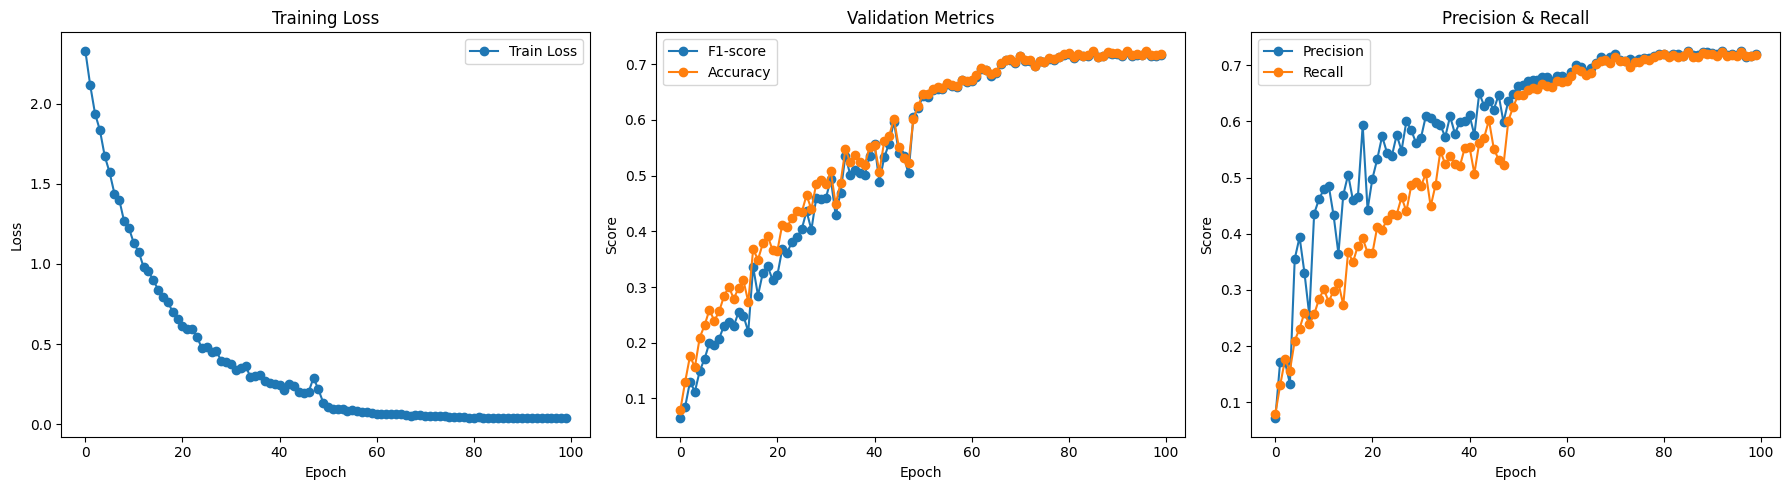

Predicting: 100%|██████████| 166/166 [03:45<00:00,  1.36s/it]

Predictions saved to shufflenet_submission.csv


In [88]:
if __name__ == "__main__":
    history = train_model()
    predict_test()